In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.figure import Figure
import matplotlib.axes._axes as axes
sns.set()

In [2]:
# import the necessary keras packages
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from loader_util.dogs_vs_cats.config import dog_vs_cats_config as config
from loader_util.preprocessing import ImageToArrayPreprocessor, \
    AspectAwarePreprocessor, SimplePreProcessor, PatchPreprocessor, \
    CropPreprocessor, MeanPreprocessor
from loader_util.datasets import SimpleDatasetLoader
from loader_util.io import HDF5DatasetGenerator
from loader_util.nn.conv import FCHeadNet, AlexNet
from loader_util.callbacks import TrainingMonitor
##
from tensorflow.keras.layers import Conv2D, Activation, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop, SGD, Adam
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from imutils import paths
import json
import os

In [3]:
# construct the image generator
aug = ImageDataGenerator(rotation_range=20,
                         zoom_range=0.15,
                         width_shift_range=0.2,
                         height_shift_range=0.2,
                         shear_range=0.15,
                         horizontal_flip=True,
                         fill_mode='nearest')

In [4]:
# load the RGB means for the trainig set
means = json.loads(open(config.DATASET_MEAN).read())

# initlaise the preprocessors
sp = SimplePreProcessor(227, 227)
mp = MeanPreprocessor(rmean=means["R"], gmean=means["G"], bmean=means["B"])
pp = PatchPreprocessor(227, 227)
iap = ImageToArrayPreprocessor()

In [5]:
# init the data generators
traingen = HDF5DatasetGenerator(dbPath=config.TRAIN_HDF5,
                                batchSize=128,
                                preprocessors=[pp, mp, iap],
                                classes=2)
validgen = HDF5DatasetGenerator(dbPath=config.VALID_HDF5,
                                batchSize=128,
                                preprocessors=[sp, mp, iap],
                                classes=2)

In [6]:
# init the optimizer
opt = Adam(lr=0.001)
model = AlexNet.build(width=227, height=227, depth=3, classes=2)
model.compile(loss="binary_crossentropy",
              optimizer=opt,
              metrics=["accuracy"])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [7]:
epochs = 75
batch_size = 128
# train the network
H = model.fit_generator(traingen.generator(),
                        steps_per_epoch=traingen.numImages//batch_size,
                        validation_data=validgen.generator(),
                        validation_steps=validgen.numImages//batch_size,
                        epochs=epochs,
                        max_queue_size=20,
                        verbose=1
                        )

Instructions for updating:
Use tf.cast instead.
Epoch 1/75
156/156 [==============================] - 221s 1s/step - loss: 3.6693 - acc: 0.5724 - val_loss: 3.0198 - val_acc: 0.6328
Epoch 2/75
156/156 [==============================] - 217s 1s/step - loss: 2.6619 - acc: 0.6448 - val_loss: 2.5616 - val_acc: 0.6735
Epoch 3/75
156/156 [==============================] - 224s 1s/step - loss: 2.1049 - acc: 0.7115 - val_loss: 1.8237 - val_acc: 0.7385
Epoch 4/75
156/156 [==============================] - 233s 1s/step - loss: 1.6637 - acc: 0.7671 - val_loss: 1.5425 - val_acc: 0.7327
Epoch 5/75
156/156 [==============================] - 216s 1s/step - loss: 1.3901 - acc: 0.7934 - val_loss: 1.9859 - val_acc: 0.6155
Epoch 6/75
156/156 [==============================] - 205s 1s/step - loss: 1.1771 - acc: 0.8171 - val_loss: 1.3502 - val_acc: 0.7463
Epoch 7/75
156/156 [==============================] - 213s 1s/step - loss: 1.0231 - acc: 0.8396 - val_loss: 1.0152 - val_acc: 0.7973
Epoch 8/75
156/156 [=

Epoch 38/75
156/156 [==============================] - 212s 1s/step - loss: 0.6000 - acc: 0.9481 - val_loss: 0.6821 - val_acc: 0.8898
Epoch 39/75
156/156 [==============================] - 221s 1s/step - loss: 0.5893 - acc: 0.9475 - val_loss: 0.6985 - val_acc: 0.8931
Epoch 40/75
156/156 [==============================] - 224s 1s/step - loss: 0.5909 - acc: 0.9483 - val_loss: 0.6998 - val_acc: 0.8914
Epoch 41/75
156/156 [==============================] - 220s 1s/step - loss: 0.5982 - acc: 0.9477 - val_loss: 0.6507 - val_acc: 0.9067
Epoch 42/75
156/156 [==============================] - 207s 1s/step - loss: 0.5885 - acc: 0.9505 - val_loss: 0.6979 - val_acc: 0.9017
Epoch 43/75
156/156 [==============================] - 234s 1s/step - loss: 0.5849 - acc: 0.9525 - val_loss: 0.7163 - val_acc: 0.8947
Epoch 44/75
156/156 [==============================] - 210s 1s/step - loss: 0.5661 - acc: 0.9512 - val_loss: 0.7120 - val_acc: 0.8873
Epoch 45/75
156/156 [==============================] - 220s 1s

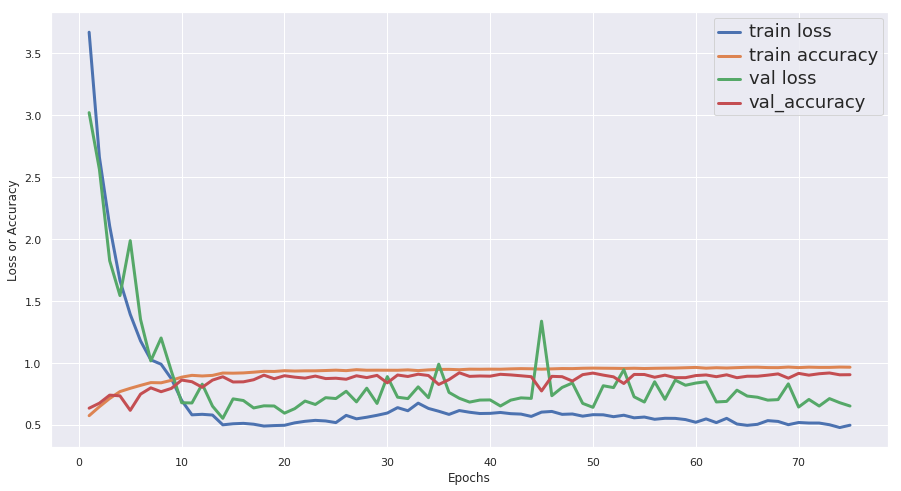

In [9]:
# plot the performance
epochs_num = range(1,epochs+1)
loss = H.history['loss']
accuracy = H.history['acc']
val_loss = H.history['val_loss']
val_accuracy = H.history['val_acc']
plot_df = pd.DataFrame(data=np.c_[epochs_num,loss,accuracy,val_loss,val_accuracy], 
                       columns=['epochs','loss', 'accuracy', 'val_loss', 'val_accuracy'])

# do the actual plots
sns.set(font_scale=1)
f, ax = plt.subplots(1, 1, figsize=(15,8))
sns.lineplot(data=plot_df, x='epochs', y='loss', ax=ax, label='train loss', linewidth=3)
sns.lineplot(data=plot_df, x='epochs', y='accuracy', ax=ax, label='train accuracy', linewidth=3)
sns.lineplot(data=plot_df, x='epochs', y='val_loss', ax=ax, label='val loss', linewidth=3)
sns.lineplot(data=plot_df, x='epochs', y='val_accuracy', ax=ax, label='val_accuracy', linewidth=3)
ax.set_ylabel('Loss or Accuracy')
ax.set_xlabel('Epochs')
plt.setp(ax.get_legend().get_texts(), fontsize='18'); # for legend text